In [1]:
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

# Process raw bvecs / bvals

In [2]:
#fetch_stanford_hardi()
dwi, gtab = read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\User\.dipy\stanford_hardi 


In [3]:
dwi = dwi.get_data()

In [4]:
[np.min(dwi), np.max(dwi)]

[0, 13321]

In [9]:
np.max(gtab.bvals)

2000.0

Deactivate interactive visualisation

In [5]:
interactive = False

In [6]:
gtab.info

B-values shape (160,)
         min 0.000000 
         max 2000.000000 
B-vectors shape (160, 3)
         min -0.999130 
         max 0.998710 


# Visualize Slices

c:\users\user\anaconda3\envs\dti\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


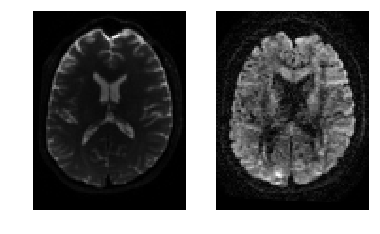

In [17]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Tractography
Constrained Spherical Deconvolution

v2

In [26]:
maskdata, mask = median_otsu(dwi, 3, 1, False,
                             vol_idx=range(10, 50), dilate=2)

In [31]:
import dipy.reconst.dti as dti
dti_wls = dti.TensorModel(gtab)
roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39))
fit_wls = dti_wls.fit(dwi)

In [32]:
FA = fractional_anisotropy(fit_wls.evals)
classifier = ThresholdTissueClassifier(FA, .2)

In [33]:
seeds = random_seeds_from_mask(FA > 0.3, seeds_count=1)

# WIP

In [19]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.7)

In [21]:
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

# Compute peaks

In [29]:
sphere = get_sphere('symmetric724')

csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

# Visualize data

In [34]:
ren = window.Renderer()
ren.add(actor.peak_slicer(csd_peaks.peak_dirs,
                          csd_peaks.peak_values,
                          colors=None))

window.show(ren, size=(900, 900))

c:\users\user\anaconda3\envs\dti\lib\site-packages\dipy\viz\colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))
